Designing filters...

Analyzing lowpass filter...

Analyzing highpass filter...

Testing filters with example signals...


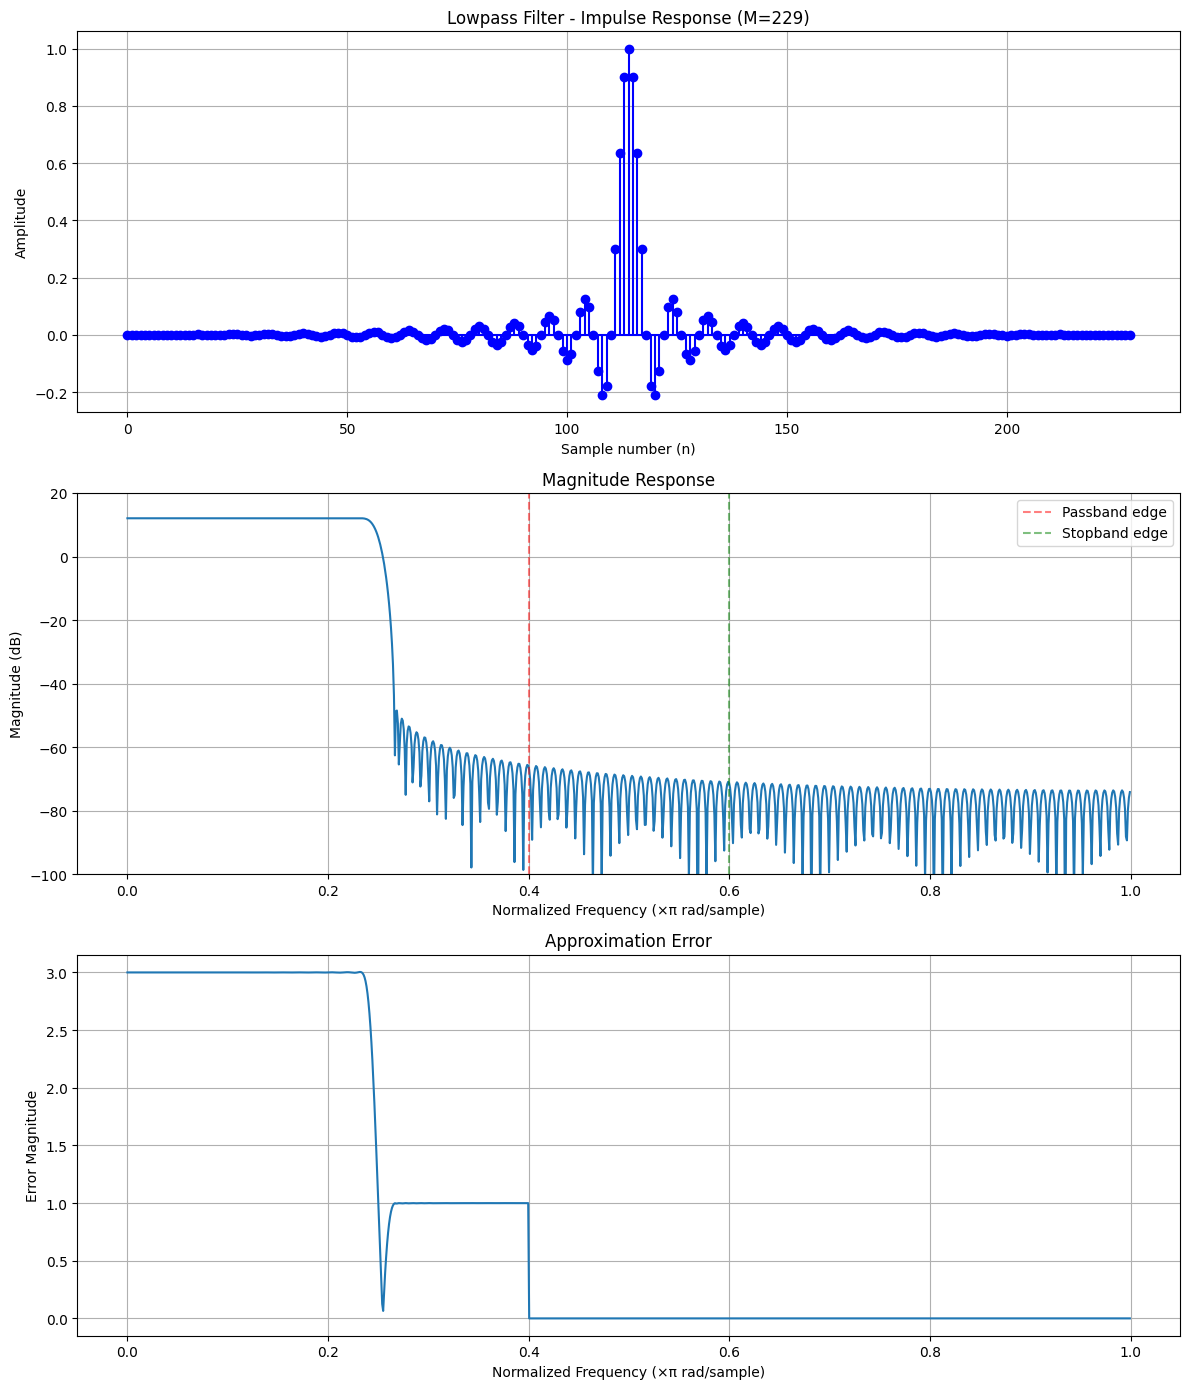

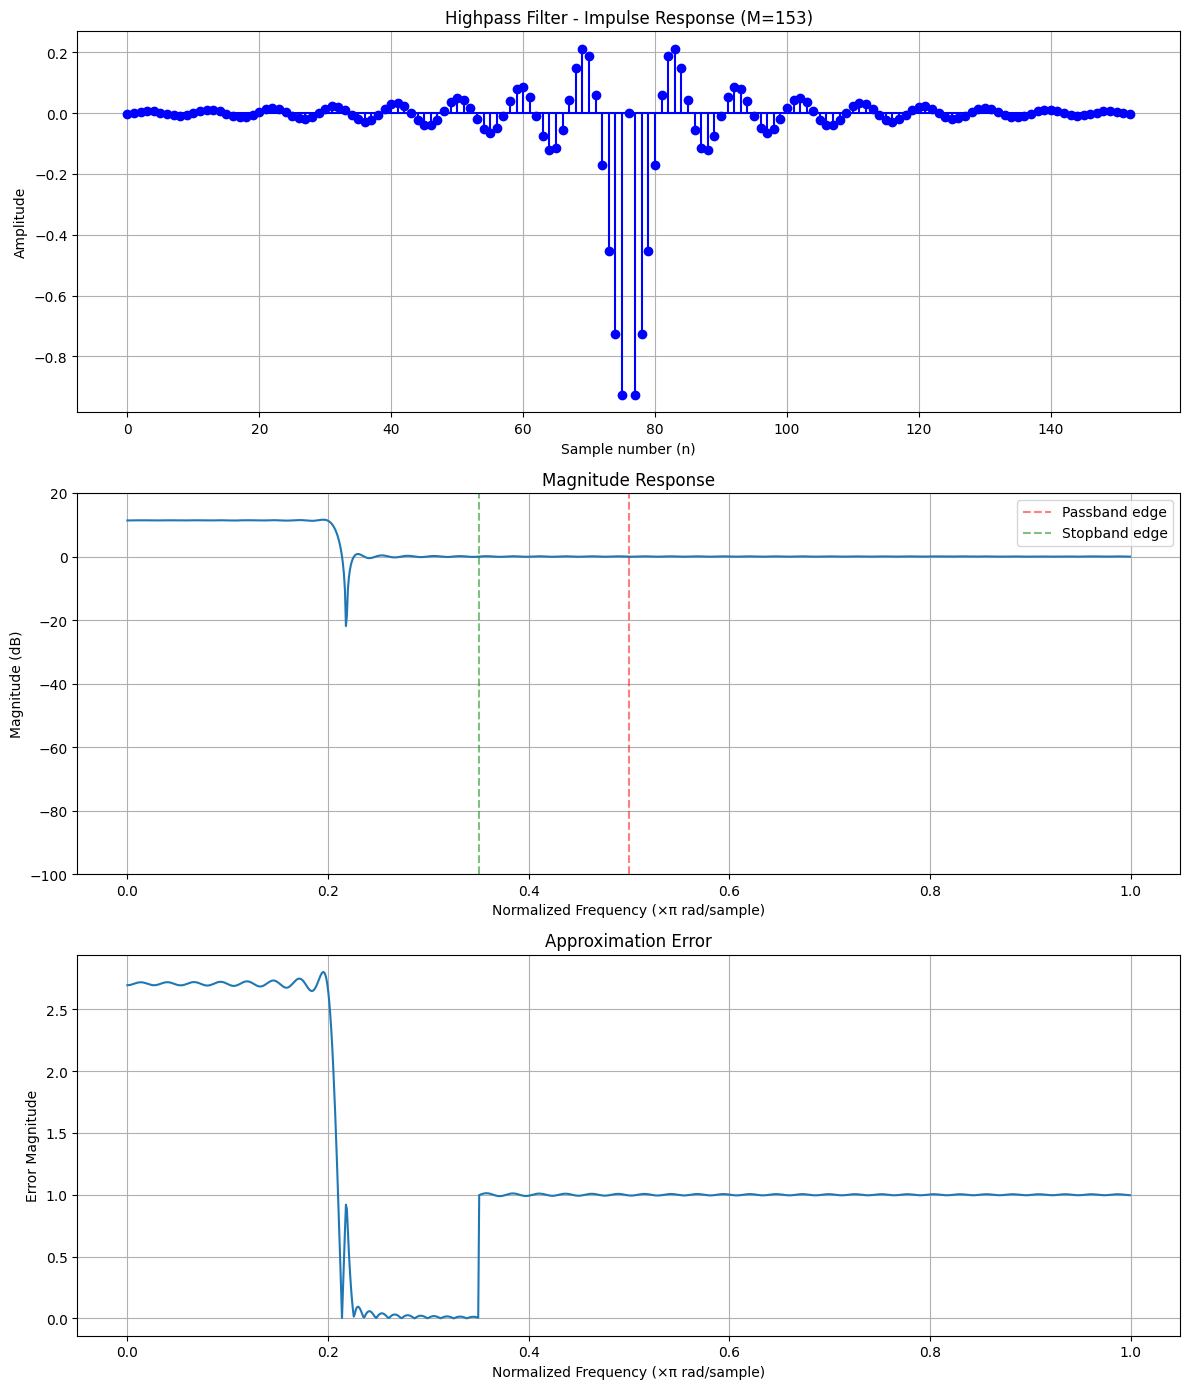

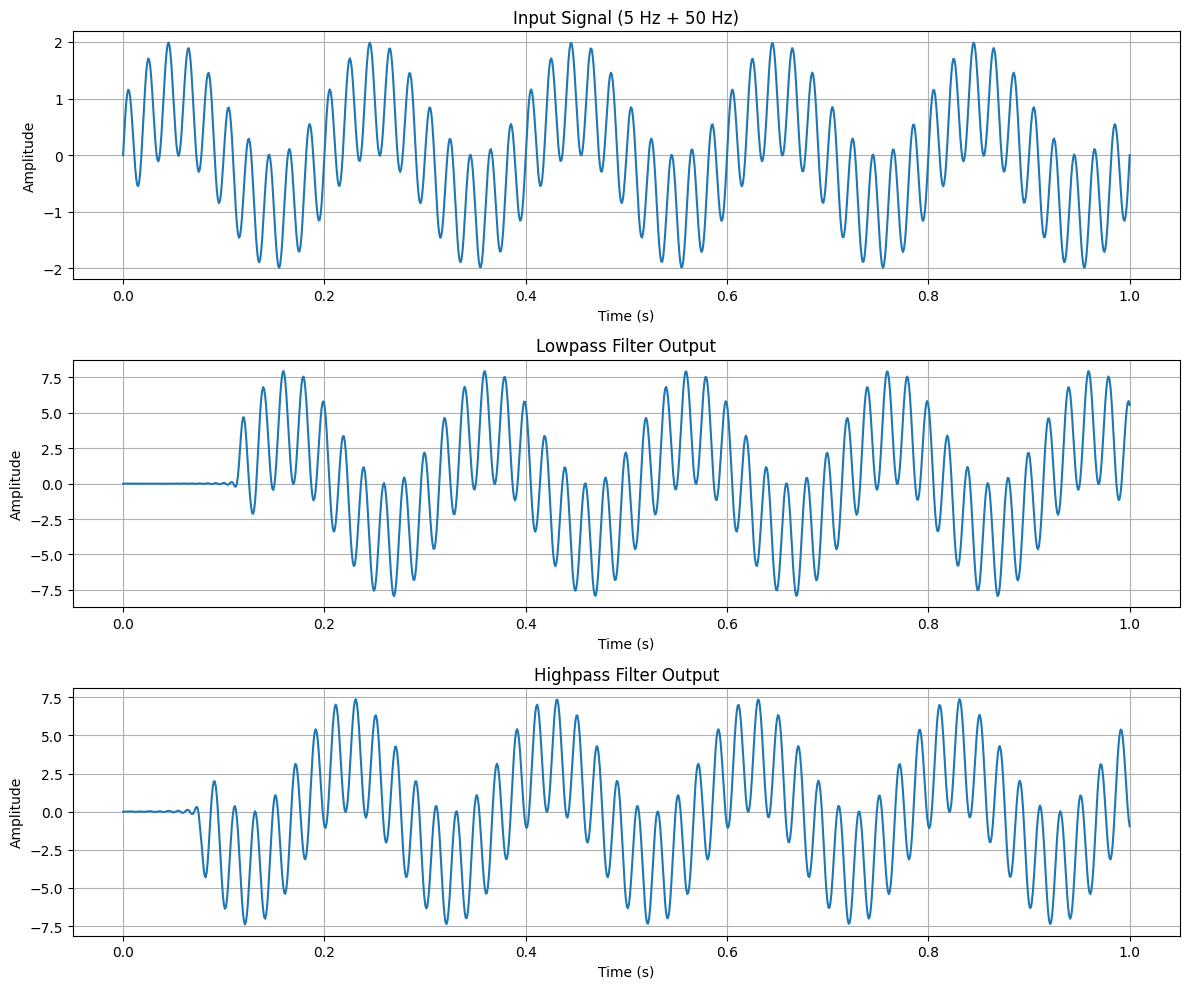


Lowpass Filter Parameters:
Order (M) = 229
Beta = 5.653
Passband edge = 0.40π
Stopband edge = 0.60π

Highpass Filter Parameters:
Order (M) = 153
Beta = 2.652
Stopband edge = 0.35π
Passband edge = 0.50π


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import i0

def kaiser_window(M, beta):
    """
    Generate Kaiser window
    M: window length
    beta: shape parameter
    """
    n = np.arange(M)
    alpha = (M-1)/2.0
    w = i0(beta * np.sqrt(1 - ((n - alpha)/alpha)**2)) / i0(beta)
    return w

def design_fir_filter(ftype, fp, fs, delta):
    """
    Design FIR filter using Kaiser window
    ftype: 'lowpass' or 'highpass'
    fp: passband frequency (normalized)
    fs: stopband frequency (normalized)
    delta: maximum ripple
    """
    # Calculate transition width and attenuation
    delta_w = abs(fs - fp)
    A = -20 * np.log10(delta)
    
    # Estimate Kaiser window parameters
    if A > 50:
        beta = 0.1102 * (A - 8.7)
    elif A >= 21:
        beta = 0.5842 * (A - 21)**0.4 + 0.07886 * (A - 21)
    else:
        beta = 0
    
    # Calculate filter order
    M = int(np.ceil((A - 7.95) / (2.285 * delta_w) + 1))
    if M % 2 == 0:
        M += 1  # Make M odd for Type II filter
    
    # Calculate cutoff frequency
    wc = 2 * np.pi * (fp + fs) / 2
    
    # Generate impulse response
    n = np.arange(M)
    alpha = (M-1) / 2
    
    if ftype == 'lowpass':
        h = np.sinc((n - alpha) * wc/(2*np.pi)) * kaiser_window(M, beta)
    else:  # highpass
        h = np.sinc(n - alpha) - np.sinc((n - alpha) * wc/(2*np.pi))
        h = h * kaiser_window(M, beta)
    
    return h, M, beta

def analyze_filter(h, title, wp, ws):
    """
    Analyze and plot filter characteristics
    """
    M = len(h)
    w, H = signal.freqz(h, worN=1024)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))
    
    # Impulse response
    ax1.stem(np.arange(M), h, 'b', markerfmt='bo', basefmt='b-')
    ax1.set_title(f'{title} - Impulse Response (M={M})')
    ax1.set_xlabel('Sample number (n)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    
    # Magnitude response
    ax2.plot(w/np.pi, 20 * np.log10(np.abs(H)))
    ax2.axvline(wp/np.pi, color='r', linestyle='--', alpha=0.5, label='Passband edge')
    ax2.axvline(ws/np.pi, color='g', linestyle='--', alpha=0.5, label='Stopband edge')
    ax2.set_title('Magnitude Response')
    ax2.set_xlabel('Normalized Frequency (×π rad/sample)')
    ax2.set_ylabel('Magnitude (dB)')
    ax2.grid(True)
    ax2.set_ylim(-100, 20)
    ax2.legend()
    
    # Approximation error
    passband_mask = w <= wp
    stopband_mask = w >= ws
    error = np.zeros_like(w)
    error[passband_mask] = np.abs(1 - np.abs(H[passband_mask]))
    error[stopband_mask] = np.abs(H[stopband_mask])
    
    ax3.plot(w/np.pi, error)
    ax3.set_title('Approximation Error')
    ax3.set_xlabel('Normalized Frequency (×π rad/sample)')
    ax3.set_ylabel('Error Magnitude')
    ax3.grid(True)
    
    plt.tight_layout()
    return fig

def test_filters(h_lp, h_hp):
    """
    Test filters with example signals
    """
    # Generate test signal
    fs = 1000  # Sampling frequency
    t = np.linspace(0, 1, fs)
    
    # Create test signal with multiple frequencies
    f1, f2 = 5, 50  # Hz
    x = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)
    
    # Apply filters
    y_lp = signal.lfilter(h_lp, 1, x)
    y_hp = signal.lfilter(h_hp, 1, x)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    plt.subplot(3,1,1)
    plt.plot(t, x)
    plt.title('Input Signal (5 Hz + 50 Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.subplot(3,1,2)
    plt.plot(t, y_lp)
    plt.title('Lowpass Filter Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(t, y_hp)
    plt.title('Highpass Filter Output')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    
# Design parameters
print("Designing filters...")

# Lowpass filter parameters
wp_lp = 0.4 * np.pi  # passband frequency
ws_lp = 0.6 * np.pi  # stopband frequency
delta_lp = 0.001     # ripple

# Highpass filter parameters
ws_hp = 0.35 * np.pi  # stopband frequency
wp_hp = 0.5 * np.pi   # passband frequency
delta_hp = 0.02       # ripple

# Design filters
h_lp, M_lp, beta_lp = design_fir_filter('lowpass', wp_lp/(2*np.pi), ws_lp/(2*np.pi), delta_lp)
h_hp, M_hp, beta_hp = design_fir_filter('highpass', wp_hp/(2*np.pi), ws_hp/(2*np.pi), delta_hp)

# Analyze filters
print("\nAnalyzing lowpass filter...")
fig_lp = analyze_filter(h_lp, "Lowpass Filter", wp_lp, ws_lp)

print("\nAnalyzing highpass filter...")
fig_hp = analyze_filter(h_hp, "Highpass Filter", wp_hp, ws_hp)

# Test filters with example signals
print("\nTesting filters with example signals...")
test_filters(h_lp, h_hp)

plt.show()

# Print filter parameters
print("\nLowpass Filter Parameters:")
print(f"Order (M) = {M_lp}")
print(f"Beta = {beta_lp:.3f}")
print(f"Passband edge = {wp_lp/np.pi:.2f}π")
print(f"Stopband edge = {ws_lp/np.pi:.2f}π")

print("\nHighpass Filter Parameters:")
print(f"Order (M) = {M_hp}")
print(f"Beta = {beta_hp:.3f}")
print(f"Stopband edge = {ws_hp/np.pi:.2f}π")
print(f"Passband edge = {wp_hp/np.pi:.2f}π")